In [ ]:
# Using Tf 2.15 cz ... well its easy to use
!pip uninstall -y tensorflow
!pip install tensorflow==2.15

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
#Mounting drive cz google wants me to
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Works!! Lets get going




In [ ]:
# All the importing stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import zipfile #Bcz we don't have hugeeee enough storage :'(
from matplotlib import image
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model



In [ ]:
#Unzip~~~
zip_path = '/content/drive/MyDrive/EuroSAT.zip'
extract_path = '/content/dataset/EuroSAT'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Dataset extracted to: {extract_path}")
dataset_folder = '/content/dataset/EuroSAT/2750/'
train_csv_path = '/content/drive/MyDrive/train.csv'
validation_csv_path = '/content/drive/MyDrive/validation.csv'
test_csv_path = '/content/drive/MyDrive/test.csv'
column_names = ["id", "path", "class_id", "class_name"]
training_df = pd.read_csv(train_csv_path, names=column_names, skiprows=1)
validation_df = pd.read_csv(validation_csv_path, names=column_names, skiprows=1)
test_df = pd.read_csv(test_csv_path, names=column_names, skiprows=1)
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)
total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")
#making everything equal!!!!!!
image_height, image_width = 64, 64
batch_size = 64 # Experimental stuff weellll...cz hyperparameter
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = ImageDataGenerator(rescale=1./255)
print("Building training set...")
training_set = train_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

print("\nBuilding validation set...")
validation_set = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\nBuilding test set...")
test_set = validation_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Dataset extracted to: /content/dataset/EuroSAT
Training set size: 18900 (70%)
Validation set size: 5400 (20%)
Test set size: 2700 (10%)
Building training set...
Found 18900 validated image filenames belonging to 10 classes.

Building validation set...
Found 5400 validated image filenames belonging to 10 classes.

Building test set...
Found 2700 validated image filenames belonging to 10 classes.


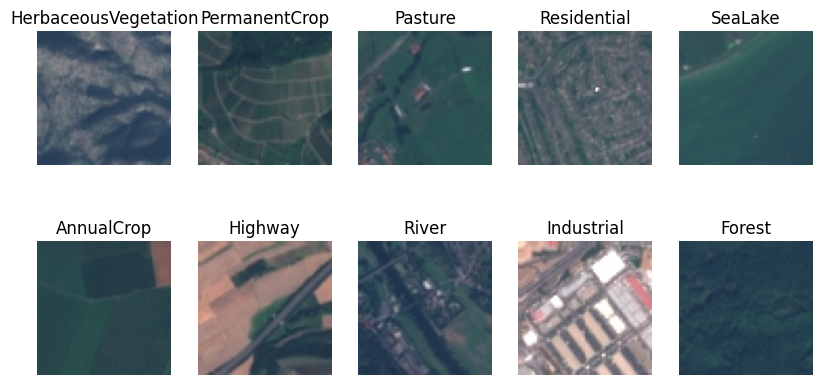

In [ ]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)
#image size and stuff
figure_height = 2
figure_width = 5
figure_size = (10, 5)
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
already_used_labels = []

imgs_to_plot = []
labels_to_plot = []

# An image from each class!!!

while len(imgs_to_plot) < 9:
    for idx in range(len(images)):
        if class_name_list[class_ids[idx].astype(bool)][0] in already_used_labels:
            pass
        else:
            imgs_to_plot.append(images[idx])
            labels_to_plot.append(class_name_list[class_ids[idx].astype(bool)][0])
            already_used_labels.append(class_name_list[class_ids[idx].astype(bool)][0])

for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(imgs_to_plot[index])
    plt.title(labels_to_plot[index])
    plt.axis("off")

plt.savefig("/content/images_examples.png") #Saving cz...welll...juuuust in case!!!

In [ ]:
#Really simple and dumb model to begin with lets see how far it takes us
#4 Conv. Layers(32,64,128,128 kernels of 3x3) ->Flatten->Dense->Dropout->Dense(10) cz 10 classes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)), #rectified linear unit (aka be positive)
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax') #softmax layer -> e**x/Sigma(e**x)
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), # Tested, low enough because anything high creaated problems, ofc can't afford anything below this due to GPU!!!
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_path = "/content/eurosat_simple_cnn_model.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True) #best saved
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) #Learning rate reduces when plateau(ofc)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1) #It is what it is
callback_list = [checkpoint, early_stopping, reduce_lr]

In [ ]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=30,
    verbose=1,)  #30 epoch cz colab allowed me

Epoch 1/30
296/296 [==============================] - 17s 58ms/step - loss: 1.4524 - accuracy: 0.4177 - val_loss: 1.2740 - val_accuracy: 0.4991 - lr: 1.0000e-04
Epoch 2/30
  3/296 [..............................] - ETA: 10s - loss: 1.3020 - accuracy: 0.4583

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 15s 52ms/step - loss: 1.2698 - accuracy: 0.5008 - val_loss: 1.0987 - val_accuracy: 0.6244 - lr: 1.0000e-04
Epoch 3/30
296/296 [==============================] - 14s 46ms/step - loss: 1.1124 - accuracy: 0.5857 - val_loss: 0.9822 - val_accuracy: 0.6580 - lr: 1.0000e-04
Epoch 4/30
296/296 [==============================] - 13s 45ms/step - loss: 1.0338 - accuracy: 0.6250 - val_loss: 0.9565 - val_accuracy: 0.6652 - lr: 1.0000e-04
Epoch 5/30
296/296 [==============================] - 15s 51ms/step - loss: 0.9635 - accuracy: 0.6523 - val_loss: 0.8597 - val_accuracy: 0.6989 - lr: 1.0000e-04
Epoch 6/30
296/296 [==============================] - 14s 46ms/step - loss: 0.9075 - accuracy: 0.6761 - val_loss: 0.8094 - val_accuracy: 0.7194 - lr: 1.0000e-04
Epoch 7/30
296/296 [==============================] - 14s 47ms/step - loss: 0.8625 - accuracy: 0.6902 - val_loss: 0.8047 - val_accuracy: 0.7076 - lr: 1.0000e-04
Epoch 8/30
296/296 [=========================

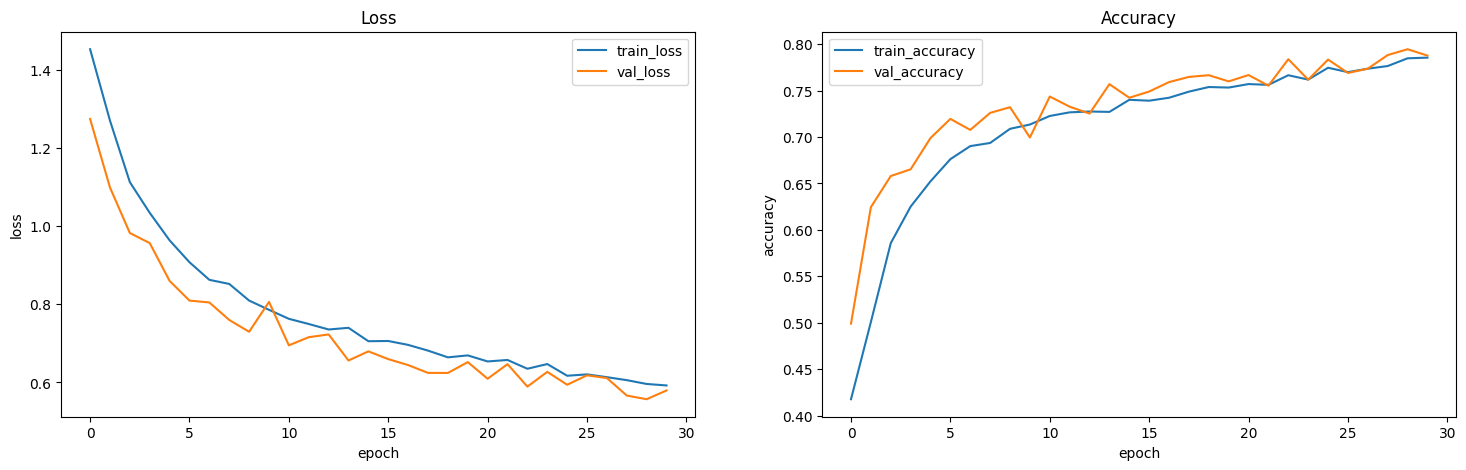

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

plt.show()
plt.savefig("/content/eurosat_simple_cnn_accuracy_loss.png")

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

43/43 [==============================] - 2s 45ms/step - loss: 0.5667 - accuracy: 0.7896
Test Loss: 0.5667493343353271 
Test Accuracy: 0.7896296381950378


Not bad for that kind of a network at all!!!!

Lets Reduce Batch Size

In [ ]:
#making everything equal!!!!!!
image_height, image_width = 64, 64
batch_size = 32 # reduced batch size
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = ImageDataGenerator(rescale=1./255)
print("Building training set...")
training_set = train_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

print("\nBuilding validation set...")
validation_set = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\nBuilding test set...")
test_set = validation_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Building training set...
Found 18900 validated image filenames belonging to 10 classes.

Building validation set...
Found 5400 validated image filenames belonging to 10 classes.

Building test set...
Found 2700 validated image filenames belonging to 10 classes.


In [ ]:
#Exactly same
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_path = "/content/eurosat_simple_cnn_model_batch_32.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
callback_list = [checkpoint, early_stopping, reduce_lr]
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=30,
    verbose=1)

Epoch 1/30
591/591 [==============================] - 17s 26ms/step - loss: 1.6164 - accuracy: 0.3513 - val_loss: 1.2316 - val_accuracy: 0.5339 - lr: 1.0000e-04
Epoch 2/30
591/591 [==============================] - 15s 26ms/step - loss: 1.1659 - accuracy: 0.5592 - val_loss: 0.9756 - val_accuracy: 0.6456 - lr: 1.0000e-04
Epoch 3/30
591/591 [==============================] - 16s 26ms/step - loss: 0.9903 - accuracy: 0.6398 - val_loss: 0.8308 - val_accuracy: 0.7063 - lr: 1.0000e-04
Epoch 4/30
591/591 [==============================] - 15s 26ms/step - loss: 0.8947 - accuracy: 0.6749 - val_loss: 0.8213 - val_accuracy: 0.7033 - lr: 1.0000e-04
Epoch 5/30
591/591 [==============================] - 15s 26ms/step - loss: 0.8434 - accuracy: 0.6934 - val_loss: 0.7419 - val_accuracy: 0.7272 - lr: 1.0000e-04
Epoch 6/30
591/591 [==============================] - 18s 30ms/step - loss: 0.8023 - accuracy: 0.7081 - val_loss: 0.7248 - val_accuracy: 0.7313 - lr: 1.0000e-04
Epoch 7/30
591/591 [==============

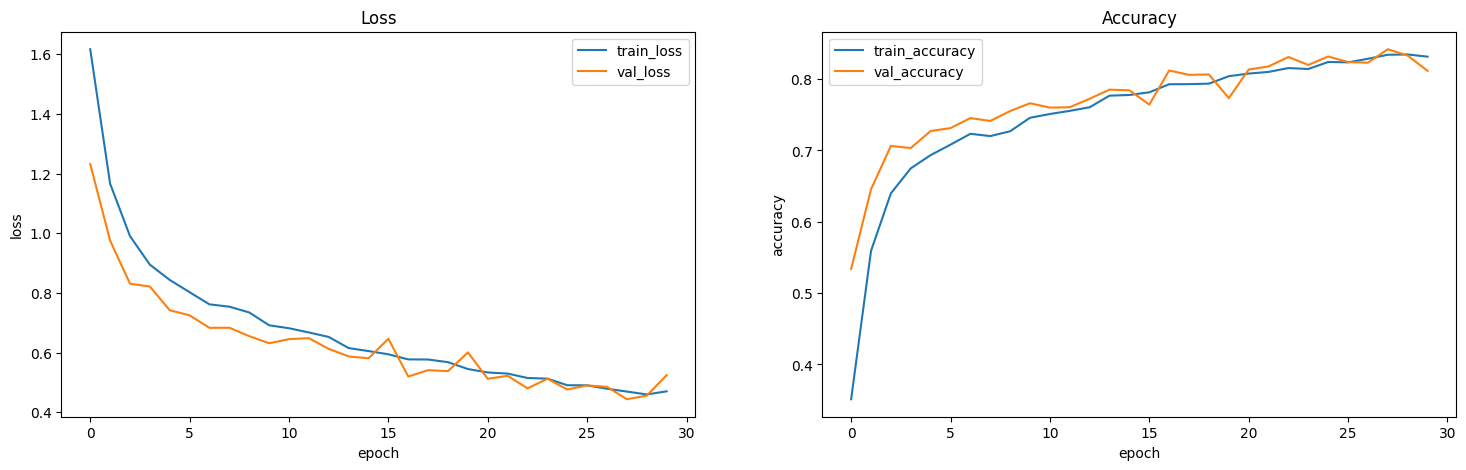

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

plt.show()
plt.savefig("/content/eurosat_simple_cnn_accuracy_loss.png")

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

85/85 [==============================] - 3s 31ms/step - loss: 0.5056 - accuracy: 0.8215
Test Loss: 0.5056487321853638 
Test Accuracy: 0.821481466293335


GOT BETTER!!!

In [ ]:
image_height, image_width = 64, 64
batch_size = 64 # Again Experimental stuff weellll...cz hyperparameter
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = ImageDataGenerator(rescale=1./255)
print("Building training set...")
training_set = train_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

print("\nBuilding validation set...")
validation_set = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("\nBuilding test set...")
test_set = validation_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Building training set...
Found 18900 validated image filenames belonging to 10 classes.

Building validation set...
Found 5400 validated image filenames belonging to 10 classes.

Building test set...
Found 2700 validated image filenames belonging to 10 classes.


In [ ]:
#Say Hello to VGG-Visual Geometry Group, A CNN for simple and effective image classification developed in 2014 by Oxford
base_vgg16 = VGG16(include_top=False,
                   weights=None, #lets go random!!!!!!!
                   input_tensor=None,
                   input_shape=(64, 64, 3),
                   pooling=None,
                   classes=10,
                   classifier_activation='softmax')

In [ ]:
class_count = len(class_name_list) #How many classes there exist
print(tf.__version__)
model = Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))
#Let us see how it looks now
model.summary()

2.15.0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 15768906 (60.15 MB)
Trainable params: 15768906 (60.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_path = "/content/eurosat_rgb_vgg16_model_no_weights.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
callback_list = [checkpoint, early_stopping, reduce_lr]

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=25,
    verbose=1,
)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7466 - accuracy: 0.2810

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 34s 95ms/step - loss: 1.7466 - accuracy: 0.2810 - val_loss: 1.2298 - val_accuracy: 0.4776 - lr: 1.0000e-04
Epoch 2/25
296/296 [==============================] - 30s 100ms/step - loss: 1.1239 - accuracy: 0.5768 - val_loss: 0.8311 - val_accuracy: 0.7004 - lr: 1.0000e-04
Epoch 3/25
296/296 [==============================] - 28s 94ms/step - loss: 0.8303 - accuracy: 0.7036 - val_loss: 0.7851 - val_accuracy: 0.7165 - lr: 1.0000e-04
Epoch 4/25
296/296 [==============================] - 28s 94ms/step - loss: 0.6734 - accuracy: 0.7616 - val_loss: 0.6374 - val_accuracy: 0.7806 - lr: 1.0000e-04
Epoch 5/25
296/296 [==============================] - 30s 101ms/step - loss: 0.5743 - accuracy: 0.8017 - val_loss: 0.4936 - val_accuracy: 0.8319 - lr: 1.0000e-04
Epoch 6/25
296/296 [==============================] - 28s 94ms/step - loss: 0.5192 - accuracy: 0.8217 - val_loss: 0.4709 - val_accuracy: 0.8315 - lr: 1.0000e-04
Epoch 7/25
296/296 [=======================

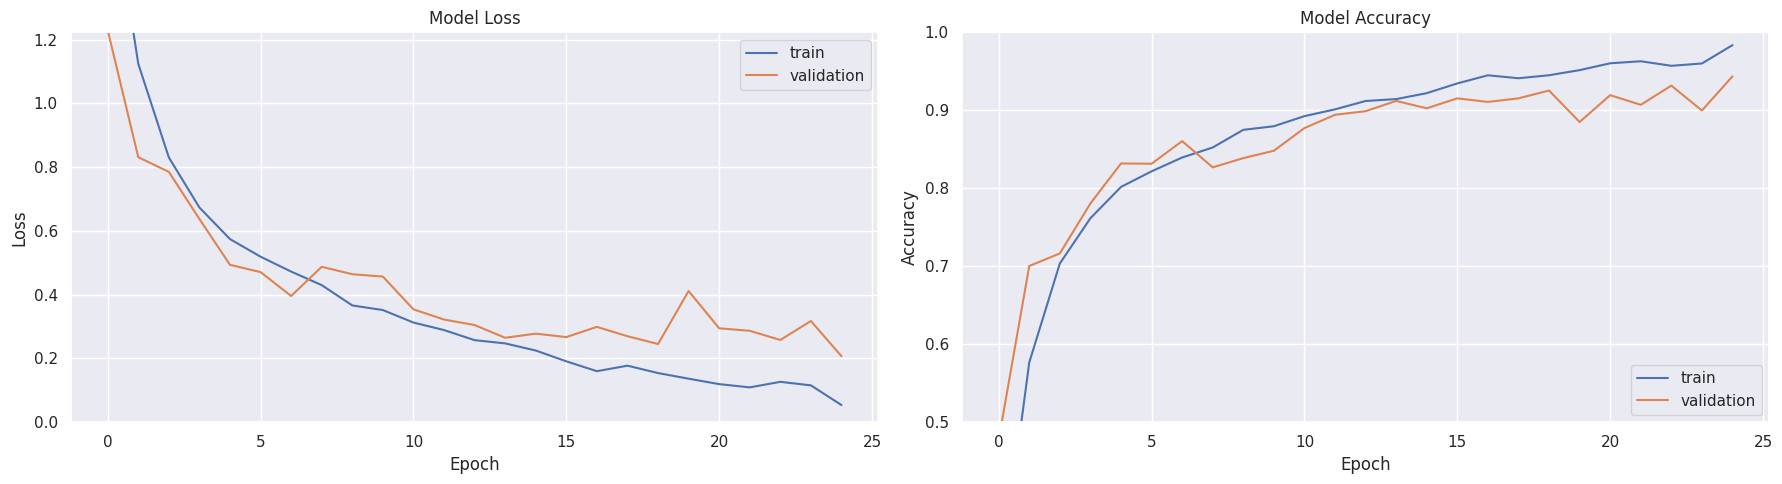

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.ylim(0, max(history.history["loss"] + history.history["val_loss"]) *0.7)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()
plt.savefig("/content/vgg16_no_weights_loss_accuracy.png")


In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

43/43 [==============================] - 1s 31ms/step - loss: 0.1978 - accuracy: 0.9433
Test Loss: 0.19777628779411316 
Test Accuracy: 0.9433333277702332


In [ ]:
base_vgg16 = VGG16(include_top=False,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=(64, 64, 3),
                   pooling=None,
                   classes=10,
                   classifier_activation='softmax')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
class_count = len(class_name_list)
print(tf.__version__)
model = Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))
#Let us see how it looks now
model.summary()

2.15.0
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                                                 
Total params: 15768906 (60.15 MB)
Trainable params: 15768906 (60.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_path = "/content/eurosat_rgb_vgg16_model_original.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
callback_list = [checkpoint, early_stopping, reduce_lr]

Wonderful!!!

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=30,
    verbose=1,
)

Epoch 1/30
296/296 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.8075

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 35s 104ms/step - loss: 0.5690 - accuracy: 0.8075 - val_loss: 0.2619 - val_accuracy: 0.9152 - lr: 1.0000e-04
Epoch 2/30
296/296 [==============================] - 30s 101ms/step - loss: 0.2063 - accuracy: 0.9340 - val_loss: 0.1551 - val_accuracy: 0.9504 - lr: 1.0000e-04
Epoch 3/30
296/296 [==============================] - 27s 92ms/step - loss: 0.1436 - accuracy: 0.9534 - val_loss: 0.1685 - val_accuracy: 0.9474 - lr: 1.0000e-04
Epoch 4/30
296/296 [==============================] - 28s 94ms/step - loss: 0.1137 - accuracy: 0.9624 - val_loss: 0.1251 - val_accuracy: 0.9591 - lr: 1.0000e-04
Epoch 5/30
296/296 [==============================] - 28s 93ms/step - loss: 0.0997 - accuracy: 0.9682 - val_loss: 0.1174 - val_accuracy: 0.9615 - lr: 1.0000e-04
Epoch 6/30
296/296 [==============================] - 27s 92ms/step - loss: 0.0815 - accuracy: 0.9738 - val_loss: 0.1497 - val_accuracy: 0.9561 - lr: 1.0000e-04
Epoch 7/30
296/296 [=======================

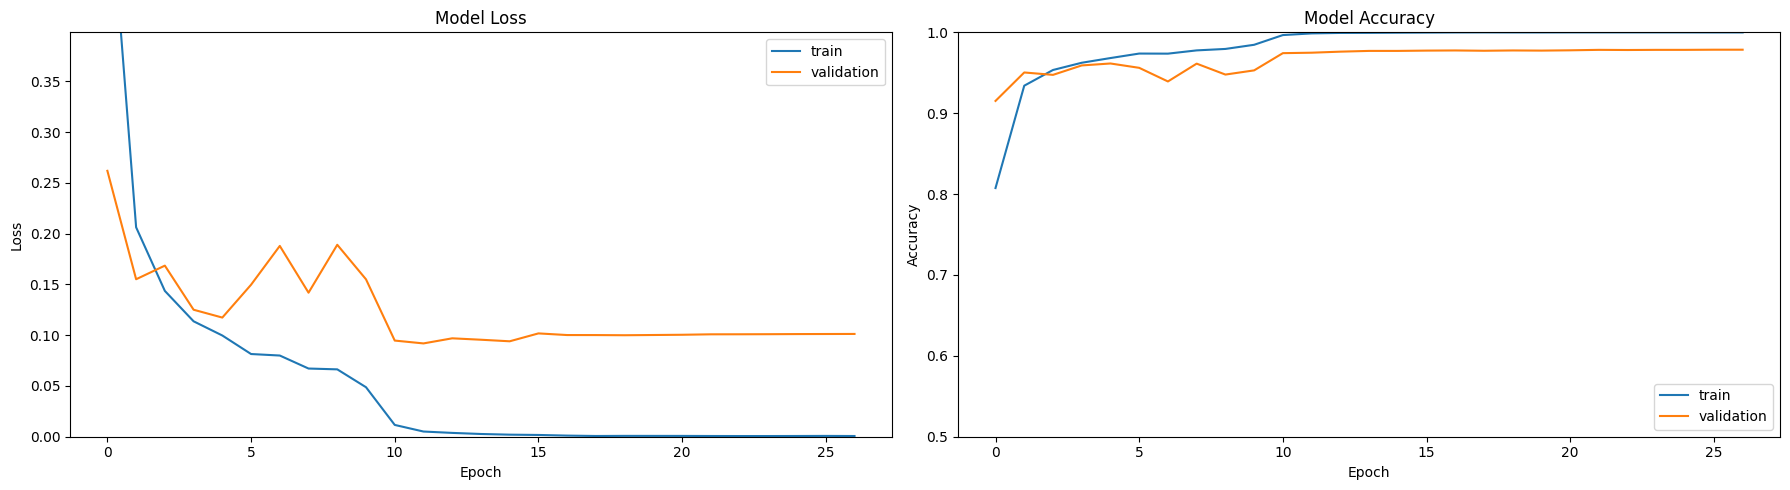

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.ylim(0, max(history.history["loss"] + history.history["val_loss"]) *0.7)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()
plt.savefig("/content/vgg16_original_loss_accuracy.png")


Weird!!! Significant Overfitting but great accuracy

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

43/43 [==============================] - 2s 34ms/step - loss: 0.0752 - accuracy: 0.9807
Test Loss: 0.0751752182841301 
Test Accuracy: 0.9807407259941101


In [ ]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))

  41/2700 [..............................] - ETA: 1:17

2700/2700 [==============================] - 1s 460us/step
              precision    recall  f1-score   support

           0     0.9800    0.9800    0.9800       300
           1     0.9868    0.9967    0.9917       300
           2     0.9731    0.9633    0.9682       300
           3     0.9877    0.9640    0.9757       250
           4     0.9881    1.0000    0.9940       250
           5     0.9695    0.9550    0.9622       200
           6     0.9414    0.9640    0.9526       250
           7     1.0000    0.9967    0.9983       300
           8     0.9722    0.9800    0.9761       250
           9     1.0000    0.9967    0.9983       300

    accuracy                         0.9807      2700
   macro avg     0.9799    0.9796    0.9797      2700
weighted avg     0.9808    0.9807    0.9807      2700



[[294   0   0   0   0   0   4   0   2   0]
 [  0 299   0   0   0   0   0   0   1   0]
 [  0   2 289   0   0   2   7   0   0   0]
 [  1   0   0 241   1   2   2   0   3   0]
 [  0   0   0   0 250   0   0   0   0   0]
 [  3   2   1   0   0 191   2   0   1   0]
 [  2   0   7   0   0   0 241   0   0   0]
 [  0   0   0   0   1   0   0 299   0   0]
 [  0   0   0   3   1   1   0   0 245   0]
 [  0   0   0   0   0   1   0   0   0 299]]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


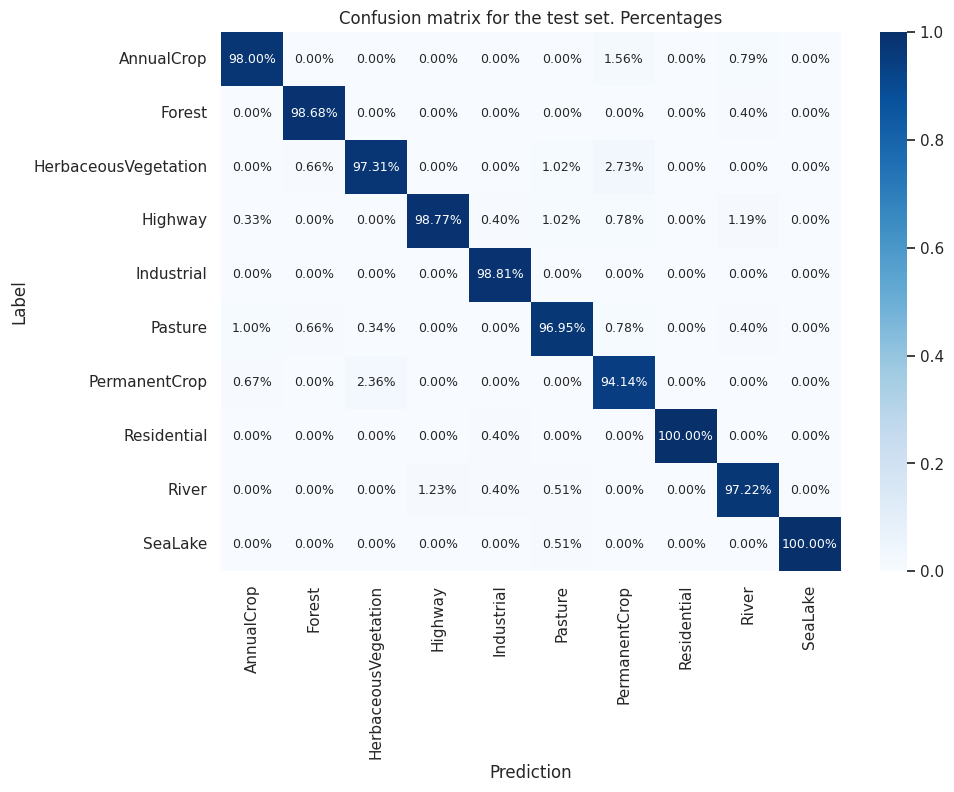

<Figure size 640x480 with 0 Axes>

In [ ]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
print(cf_matrix)
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array,
    index=class_name_list,
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True,
           cmap="Blues", annot_kws={"size": 9}, fmt='.2%')
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set. Percentages")
plt.show()
plt.savefig("/content/vgg19_exp1_confusion_percentages.png")

52 wrong predictions out of 2700


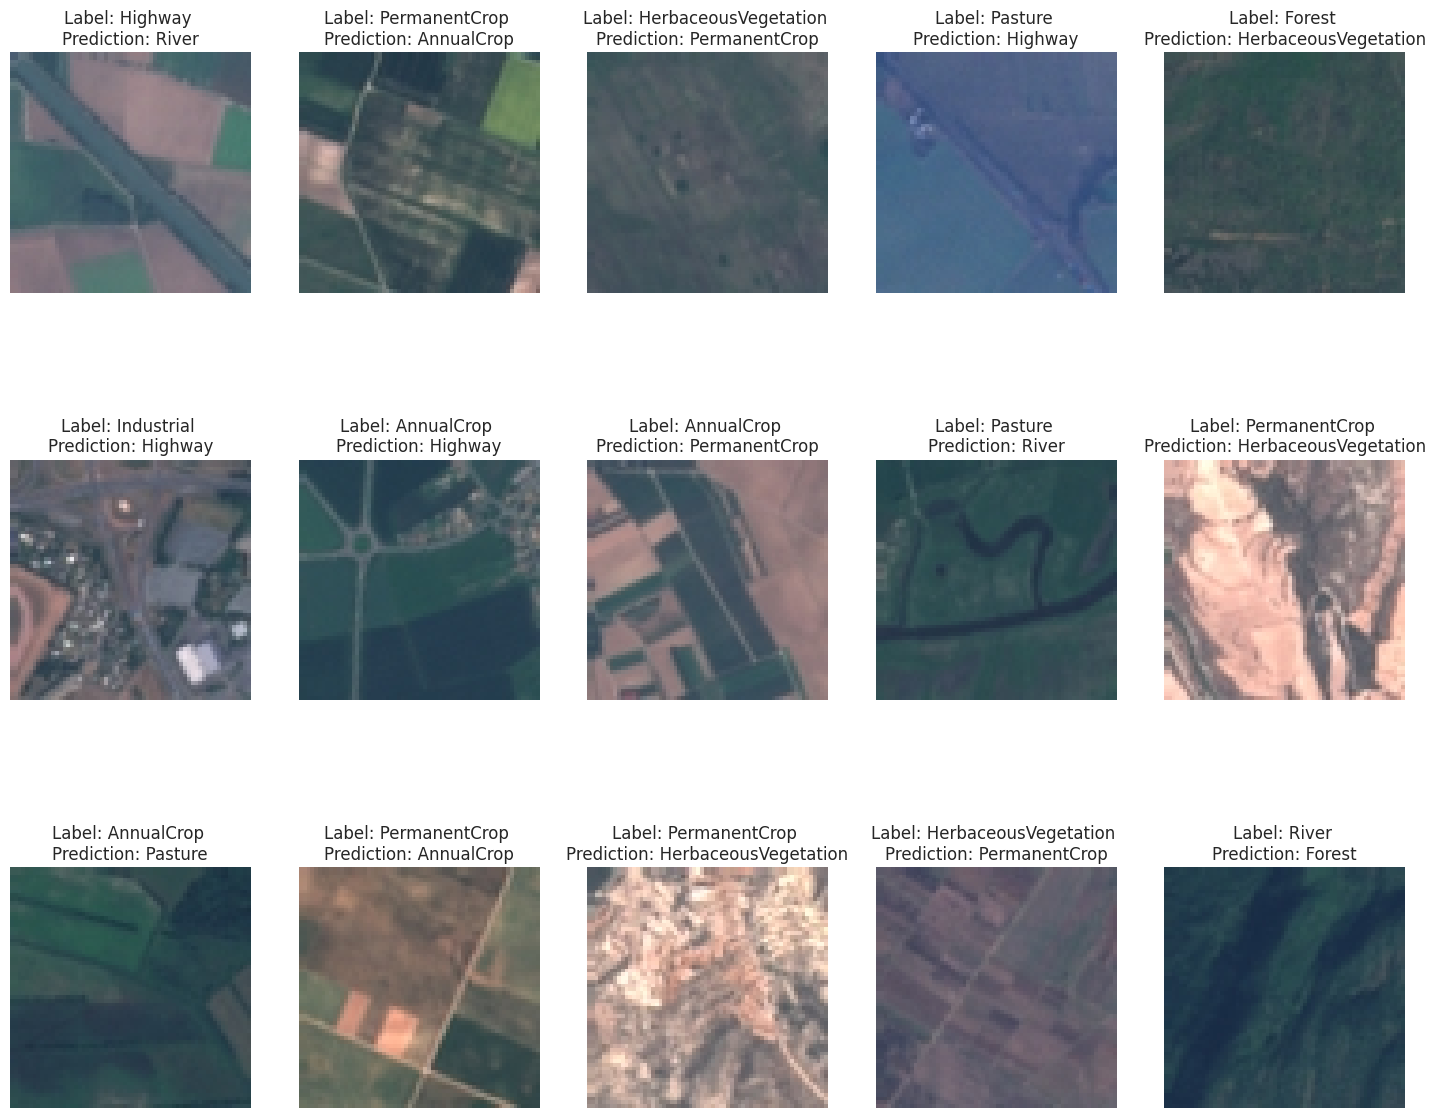

In [ ]:
#Find mis-judged images
results_df = pd.DataFrame(
    {
        "label": test_set.labels,
        "prediction": predicted_class_ids,
        "path": test_set.filepaths
    }
)
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_height = 3
figure_width = 5

figure_size = (18, 15)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):

    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)

    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

plt.savefig("/content/vgg19_mislabeled_results.png")

Let us add an L2 regularizer!!!! Lets tackle overfitting

In [ ]:
from keras.regularizers import l2

# VGG16 base model,We  have seen it before!!!
base_vgg16 = VGG16(include_top=False,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=(64, 64, 3),
                   pooling=None)

class_count = len(class_name_list)
model = Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(Dropout(0.5))

# L2 regularization
model.add(Dense(units=512, activation="relu",
                kernel_initializer="he_normal",
                kernel_regularizer=l2(0.01)))  # L2 regularization with weight decay
model.add(Dense(class_count, activation="softmax"))
model_path = "/content/eurosat_rgb_vgg16_model_regularized.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
callback_list = [checkpoint, early_stopping, reduce_lr]
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=20,
    verbose=1,
)


Epoch 1/20
296/296 [==============================] - ETA: 0s - loss: 7.2525 - accuracy: 0.7945

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 36s 101ms/step - loss: 7.2525 - accuracy: 0.7945 - val_loss: 4.4527 - val_accuracy: 0.9270 - lr: 1.0000e-04
Epoch 2/20
296/296 [==============================] - 28s 96ms/step - loss: 3.1974 - accuracy: 0.9326 - val_loss: 2.2489 - val_accuracy: 0.9380 - lr: 1.0000e-04
Epoch 3/20
296/296 [==============================] - 29s 98ms/step - loss: 1.6769 - accuracy: 0.9547 - val_loss: 1.2654 - val_accuracy: 0.9524 - lr: 1.0000e-04
Epoch 4/20
296/296 [==============================] - 28s 94ms/step - loss: 1.0052 - accuracy: 0.9571 - val_loss: 0.8148 - val_accuracy: 0.9559 - lr: 1.0000e-04
Epoch 5/20
296/296 [==============================] - 28s 96ms/step - loss: 0.6478 - accuracy: 0.9620 - val_loss: 0.5528 - val_accuracy: 0.9606 - lr: 1.0000e-04
Epoch 6/20
296/296 [==============================] - 28s 96ms/step - loss: 0.4293 - accuracy: 0.9704 - val_loss: 0.4160 - val_accuracy: 0.9589 - lr: 1.0000e-04
Epoch 7/20
296/296 [========================

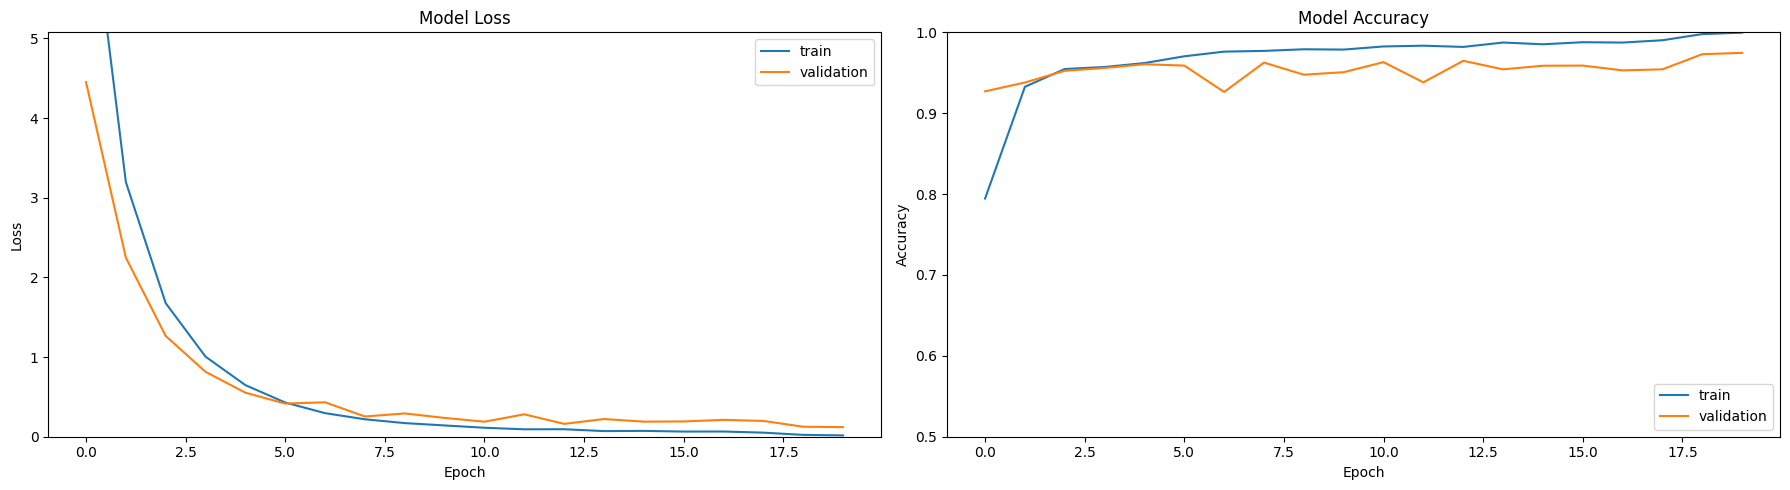

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.ylim(0, max(history.history["loss"] + history.history["val_loss"]) *0.7)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()
plt.savefig("/content/vgg19_original_loss_accuracy.png")


Better than before, not much overfitting

In [ ]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.ylim(0, max(history.history["loss"] + history.history["val_loss"]) *0.7)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()
plt.savefig("/content/vgg19_original_loss_accuracy.png")


43/43 [==============================] - 2s 35ms/step - loss: 0.1041 - accuracy: 0.9800
Test Loss: 0.10413076728582382 
Test Accuracy: 0.9800000190734863


In [ ]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))

  42/2700 [..............................] - ETA: 2:14

2700/2700 [==============================] - 2s 783us/step
              precision    recall  f1-score   support

           0     0.9732    0.9700    0.9716       300
           1     0.9867    0.9900    0.9884       300
           2     0.9636    0.9700    0.9668       300
           3     0.9797    0.9640    0.9718       250
           4     0.9880    0.9880    0.9880       250
           5     0.9648    0.9600    0.9624       200
           6     0.9409    0.9560    0.9484       250
           7     0.9967    0.9967    0.9967       300
           8     0.9721    0.9760    0.9741       250
           9     1.0000    0.9933    0.9967       300

    accuracy                         0.9774      2700
   macro avg     0.9766    0.9764    0.9765      2700
weighted avg     0.9775    0.9774    0.9774      2700



[[291   0   0   0   0   1   6   0   2   0]
 [  0 297   1   0   0   0   0   0   2   0]
 [  0   2 291   0   0   3   4   0   0   0]
 [  1   0   0 241   2   1   2   0   3   0]
 [  0   0   0   1 247   0   1   1   0   0]
 [  2   0   4   0   0 192   2   0   0   0]
 [  5   0   6   0   0   0 239   0   0   0]
 [  0   0   0   0   1   0   0 299   0   0]
 [  0   1   0   4   0   1   0   0 244   0]
 [  0   1   0   0   0   1   0   0   0 298]]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


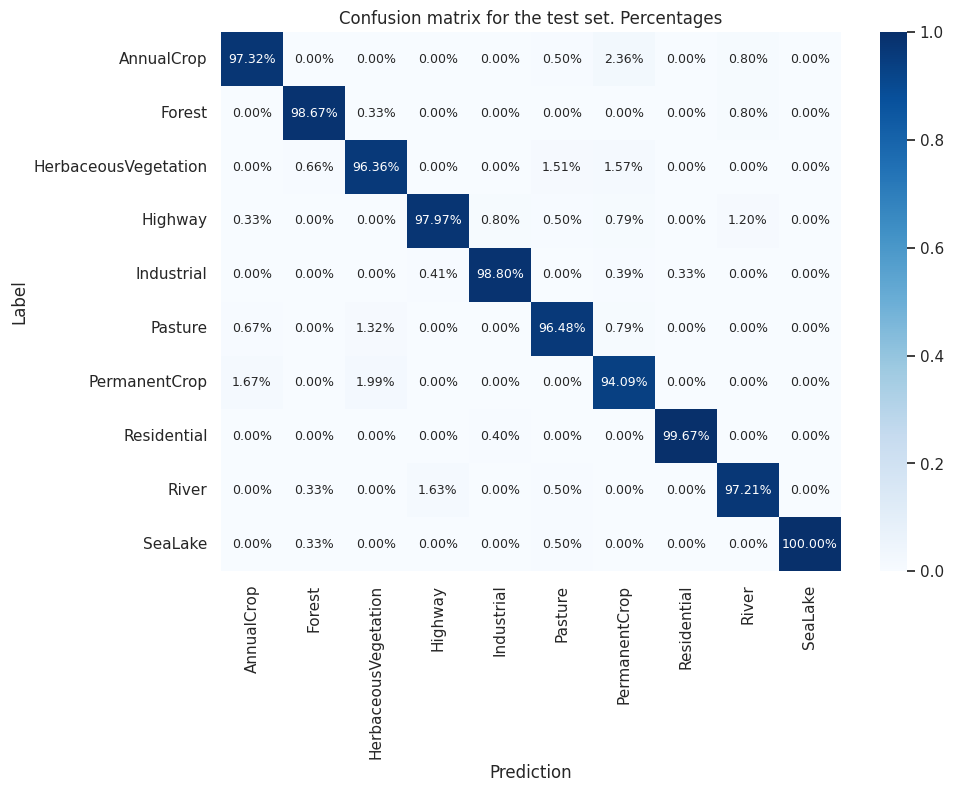

<Figure size 640x480 with 0 Axes>

In [ ]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
print(cf_matrix)
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array,
    index=class_name_list,
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True,
           cmap="Blues", annot_kws={"size": 9}, fmt='.2%')
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set. Percentages")
plt.show()
plt.savefig("/content/vgg19_regularized_exp1_confusion_percentages.png")

61 wrong predictions out of 2700


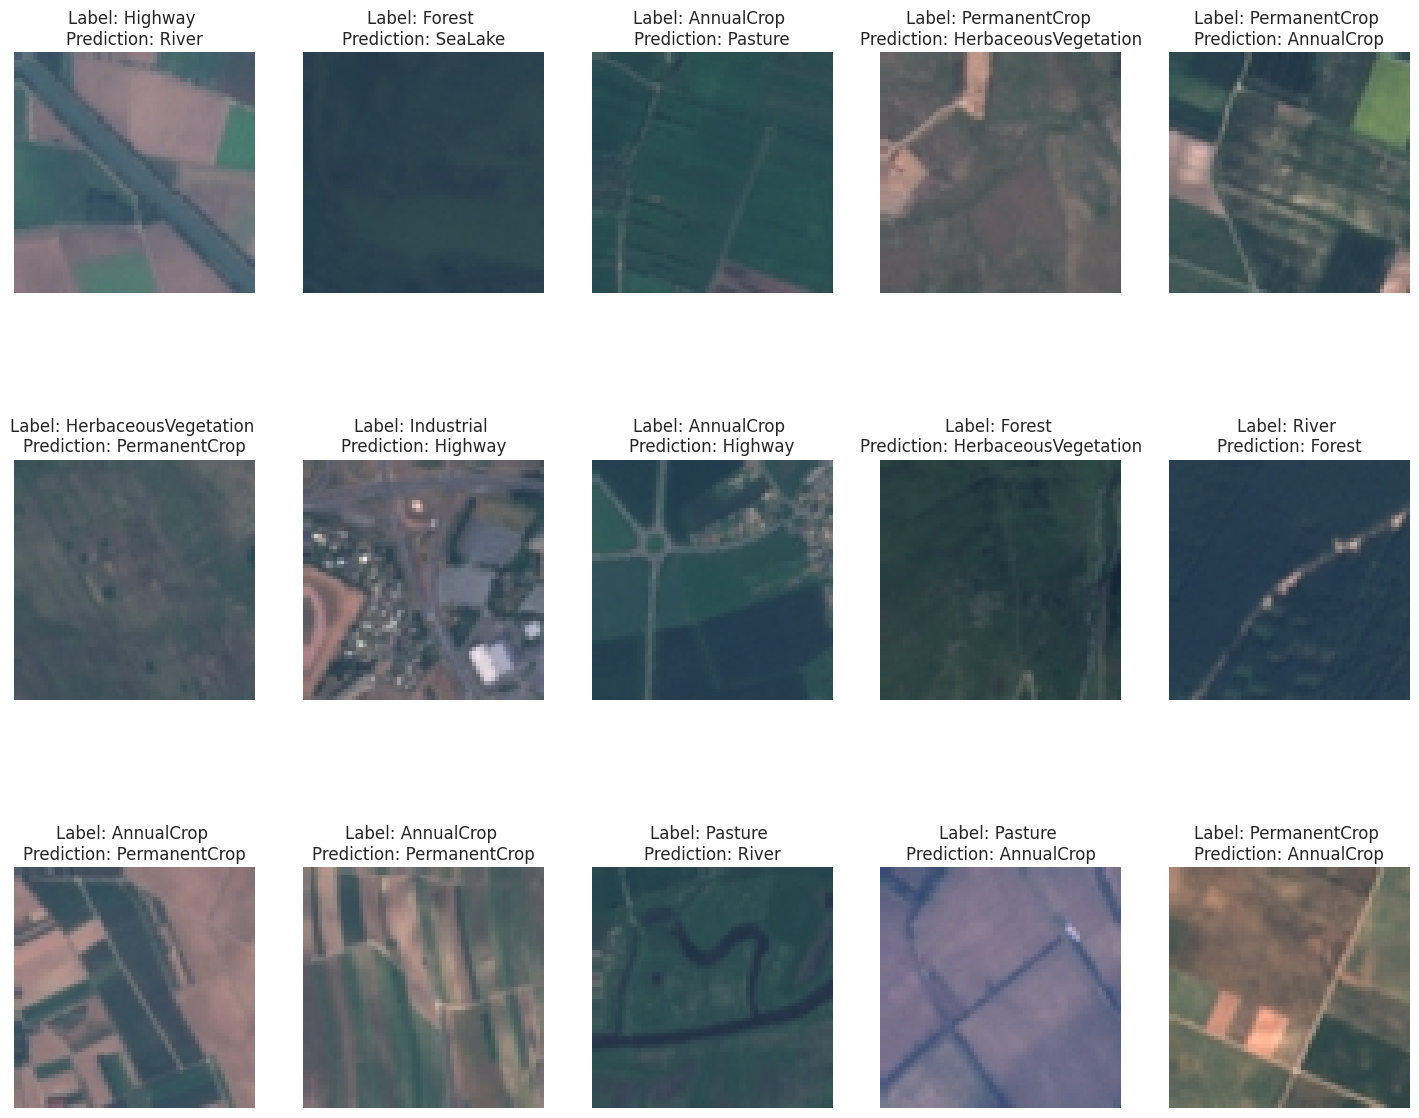

In [ ]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels,
        "prediction": predicted_class_ids,
        "path": test_set.filepaths
    }
)
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_height = 3
figure_width = 5

figure_size = (18, 15)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):

    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)

    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

plt.savefig("/content/vgg19_regularized_mislabeled_results.png")

In [ ]:
#Checking if we can load model, this stuff gave a lot of pain earlier with tf 17 implementation
model_path = "/content/eurosat_rgb_vgg16_model_original.h5"
load_model(model_path)

Works Finally!!!

VGG19!!

In [ ]:
#Let us try VGG19, a slightly more advanced model
base_vgg19 = VGG19(include_top=False,
                   weights='imagenet',
                   input_tensor=None,
                   input_shape=(64, 64, 3),
                   pooling=None,
                   classes=10,
                   classifier_activation='softmax')


In [ ]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_vgg19)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

In [ ]:
model_path = "/content/eurosat_rgb_vgg19_model.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [ ]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=30,
    verbose=1,
)

Epoch 1/30
296/296 [==============================] - 42s 126ms/step - loss: 0.6768 - accuracy: 0.7787 - val_loss: 0.3282 - val_accuracy: 0.8943 - lr: 1.0000e-04
Epoch 2/30
296/296 [==============================] - 33s 111ms/step - loss: 0.2636 - accuracy: 0.9160 - val_loss: 0.2035 - val_accuracy: 0.9346 - lr: 1.0000e-04
Epoch 3/30
296/296 [==============================] - 32s 109ms/step - loss: 0.1979 - accuracy: 0.9384 - val_loss: 0.2215 - val_accuracy: 0.9346 - lr: 1.0000e-04
Epoch 4/30
296/296 [==============================] - 32s 109ms/step - loss: 0.1493 - accuracy: 0.9552 - val_loss: 0.2353 - val_accuracy: 0.9330 - lr: 1.0000e-04
Epoch 5/30
296/296 [==============================] - 33s 111ms/step - loss: 0.1534 - accuracy: 0.9523 - val_loss: 0.2005 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 6/30
296/296 [==============================] - 33s 112ms/step - loss: 0.1176 - accuracy: 0.9632 - val_loss: 0.1754 - val_accuracy: 0.9443 - lr: 1.0000e-04
Epoch 7/30
296/296 [========

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

43/43 [==============================] - 2s 55ms/step - loss: 0.0698 - accuracy: 0.9826
Test Loss: 0.06977824121713638 
Test Accuracy: 0.9825925827026367


Let us do some adversial testing, starting with an augmix like thingyy!!

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

test_images, test_labels = [], []
for _ in range(400):
    img, label = next(test_set)
    test_images.extend(img)
    test_labels.extend(label)

test_images, test_labels = np.array(test_images), np.array(test_labels)


augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Apply augmentation to the test images
augmented_images = np.array([augmenter.random_transform(img) for img in test_images])

# Evaluate the model on augmented test images
loss, accuracy = model.evaluate(augmented_images, test_labels, verbose=1)
print("Test Loss with Augmented Images:", loss, "\nTest Accuracy with Augmented Images:", accuracy)


786/786 [==============================] - 16s 19ms/step - loss: 0.2107 - accuracy: 0.9462
Test Loss with Augmented Images: 0.2107182741165161 
Test Accuracy with Augmented Images: 0.9461642503738403


Let us do smth better, Let us apply FGSM to prove adversial attacks work very well

In [ ]:
def fgsm_attack(image, epsilon, gradient):
    signed_grad = tf.sign(gradient)
    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image
epsilon = 0.01
test_images, test_labels = [], []
for _ in range(200): #Lets restrict ourselves well cz GPU :'(
    img, label = next(test_set)
    test_images.extend(img)
    test_labels.extend(label)

test_images, test_labels = np.array(test_images), np.array(test_labels)
perturbed_images = []
for img in test_images:
    img_tensor = tf.convert_to_tensor(img.reshape(1, *img.shape))
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        loss = tf.keras.losses.categorical_crossentropy(test_labels[0].reshape(1, -1), prediction)
    gradient = tape.gradient(loss, img_tensor)

    # Applying FGSM attack!!!!!!!!!!!
    perturbed_img = fgsm_attack(img_tensor, epsilon, gradient)
    perturbed_images.append(perturbed_img.numpy().squeeze())

perturbed_images = np.array(perturbed_images)

loss, accuracy = model.evaluate(perturbed_images, test_labels, verbose=1)
print("Test Loss with FGSM-perturbed Images:", loss, "\nTest Accuracy with FGSM-perturbed Images:", accuracy)


392/392 [==============================] - 8s 21ms/step - loss: 1.5373 - accuracy: 0.8155
Test Loss with FGSM-perturbed Images: 1.537313461303711 
Test Accuracy with FGSM-perturbed Images: 0.8154705166816711


Gets better for regularized model

392/392 [==============================] - 6s 16ms/step - loss: 1.5367 - accuracy: 0.8683
Test Loss with FGSM-perturbed Images: 1.536657691001892
Test Accuracy with FGSM-perturbed Images: 0.868341326713562


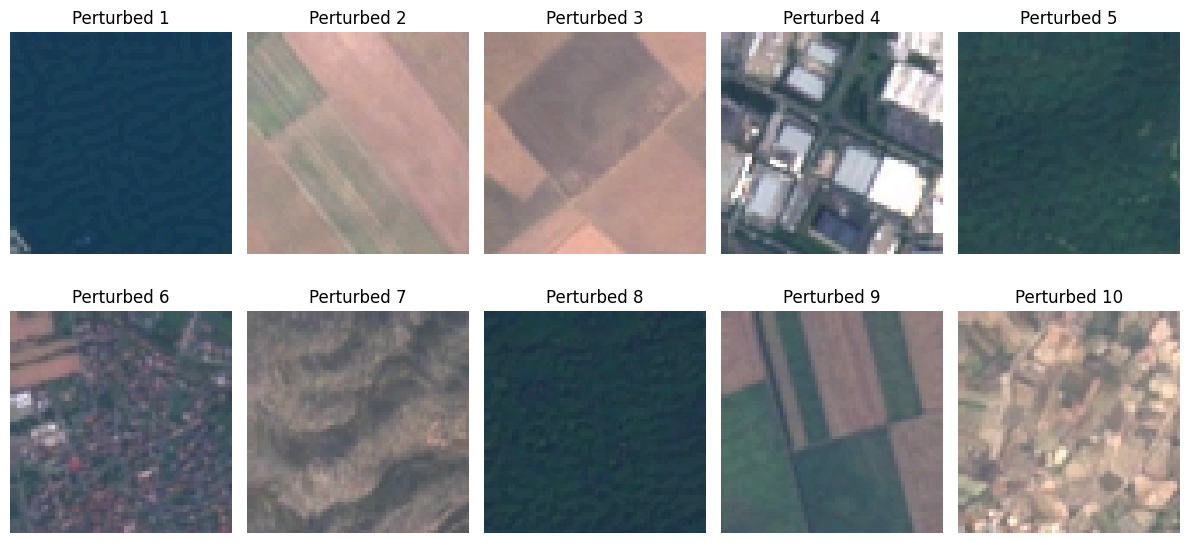

In [ ]:

model_path = "/content/eurosat_rgb_vgg16_model_regularized.h5"
model = tf.keras.models.load_model(model_path)
def fgsm_attack(image, epsilon, gradient):
    signed_grad = tf.sign(gradient)
    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

epsilon = 0.01
test_images, test_labels = [], []
for _ in range(200):
    img, label = next(test_set)
    test_images.extend(img)
    test_labels.extend(label)

test_images, test_labels = np.array(test_images), np.array(test_labels)
perturbed_images = []

os.makedirs("/content/adversarial_images", exist_ok=True)
for idx, img in enumerate(test_images):
    img_tensor = tf.convert_to_tensor(img.reshape(1, *img.shape))
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        loss = tf.keras.losses.categorical_crossentropy(test_labels[0].reshape(1, -1), prediction)
    gradient = tape.gradient(loss, img_tensor)
    perturbed_img = fgsm_attack(img_tensor, epsilon, gradient)
    perturbed_images.append(perturbed_img.numpy().squeeze())
    plt.imsave(f"/content/adversarial_images/perturbed_image_{idx + 1}.png", perturbed_img.numpy().squeeze())
perturbed_images = np.array(perturbed_images)
loss, accuracy = model.evaluate(perturbed_images, test_labels, verbose=1)
print(f"Test Loss with FGSM-perturbed Images: {loss}\nTest Accuracy with FGSM-perturbed Images: {accuracy}")
def plot_images(images):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Perturbed {i + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_images(perturbed_images[:10])


In [1]:
%pip install joblip
import joblib

# Assuming `model` is your trained model
joblib.dump(model, 'model.pkl')

ERROR: Could not find a version that satisfies the requirement joblip (from versions: none)
ERROR: No matching distribution found for joblip
You should consider upgrading via the 'c:\users\91934\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


NameError: name 'model' is not defined